## Weather-AQI MCP Assistant
**`Weather-AQI MCP Assistant`** is an interactive, asynchronous assistant that brings together real-time weather and AQI (Air Quality Index) data using powerful **MCP** (Model Context Protocol) servers. There are 3 MCP servers that are created using **`FastMCP`** which is a high-level, Pythonic framework inspired by FastAPI that simplifies MCP implementation.\
It seamlessly connects to dedicated weather and AQI tools on **Intel® Core™ Ultra Processors** then uses [**Qwen/Qwen2.5-3B-Instruct**](https://huggingface.co/Qwen/Qwen2.5-3B-Instruct) to analyze the data and generate clear, actionable health and safety recommendations. The Qwen2.5-3B-Instruct model is loaded using the [**PyTorch XPU backend**](https://docs.pytorch.org/docs/stable/notes/get_start_xpu.html) to leverage Intel hardware acceleration.This assistant helps users stay informed about environmental conditions and make better decisions for their well-being. Designed with async operations and SSE connections, it’s perfect for modern, event-driven pipelines

## Workflow
This diagram illustrates how the Weather-AQI MCP Assistant operates end-to-end within an AI PC environment, combining MCP Compliant Servers, a client, and external APIs. The servers are created using **`FastMCP`** which is a high-level, **`Pythonic framework`** inspired by FastAPI that simplifies MCP implementation.

1. **Air Quality Index(AQI) server:** Returns AQI data and air pollutant levels of the input location.
2. **Weather server:** Returns Weather report like Temparature and wind speed in the user specified location.
3. **LLM Inferencing server:** Based on the weather and AQI reports generated from the above servers, the model generates Health advice and safety guidelines and necessary precautions accordingly.
4. **Weather & AQI Advisory:** This notebook (acts as MCP Client) coordinates the workflow between these 3 servers "

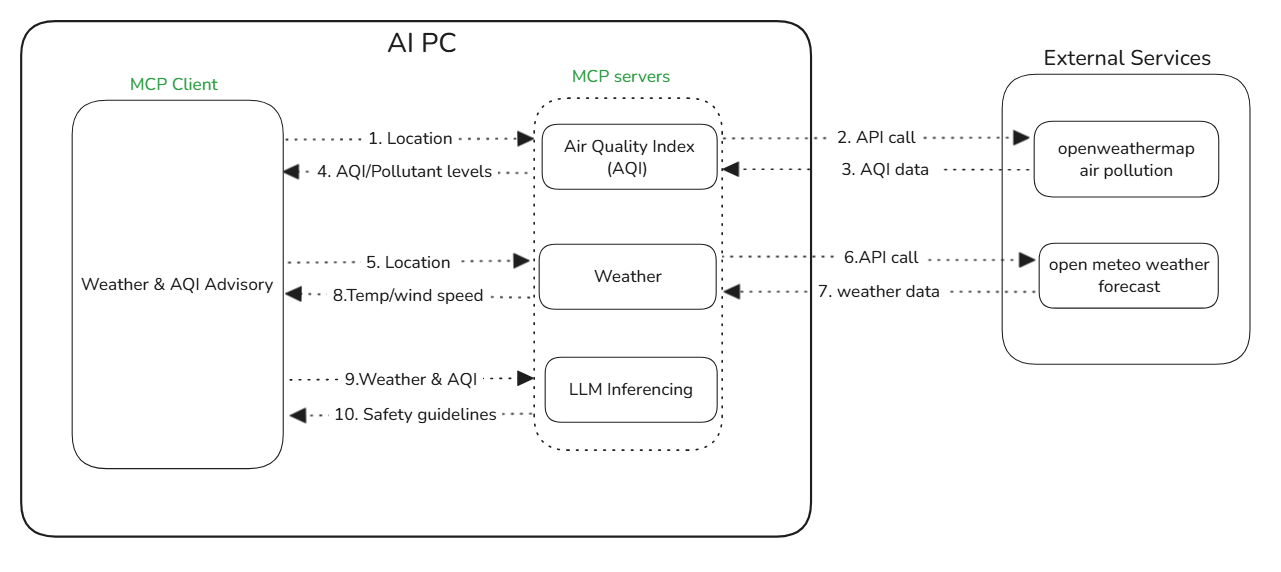

## Run all MCP servers locally:

This sample has 3 MCP servers (runs on 3 different ports):\
     - **Weather** (port - 8000)\
     - **AQI (Air Quality Index)** (port - 8001) 
     \
     - **LLM Inference** (port - 8002)
  
To run them all, open **3 separate terminals**
  
**Terminal 1**: Start the Weather MCP server -
```
uv run weather-server.py

INFO:     Started server process [41280]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
```
**Terminal 2**: Start the AQI MCP server - 
```
uv run aqi_server.py

mcp = FastMCP("Air Quality Index", host="0.0.0.0", port=8001)
[07/14/25 12:30:07] INFO     Starting MCP server 'Air Quality      server.py:848
                             Index' with transport 'sse' on        
                             http://0.0.0.0:8001/sse
INFO:     Started server process [42084]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8001 (Press CTRL+C to quit)
```
**Terminal 3**: Start the LLM Inferencing MCP server -
```
uv run llm_inference_server.py

mcp = FastMCP("LLM-Inference", host="0.0.0.0", port=8002)
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.
Loading checkpoint shards: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:18<00:00,  9.12s/it]
Device set to use xpu:0
[07/14/25 12:34:30] INFO     Starting MCP server 'LLM-Inference'   server.py:848
                             with transport 'sse' on
                             http://0.0.0.0:8002/sse
INFO:     Started server process [31956]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8002 (Press CTRL+C to quit)
```

## Import necessary packages
Import all the necessary packages and libraries. Apply nest_asyncio to allow nested event loops

In [1]:
import nest_asyncio
nest_asyncio.apply()

import asyncio
import os
from fastmcp import Client

## Define the MCP Client class AQI_Weather_Advisor
This class contains definitions of async methods i.e. `get_weather()`, `get_aqi_report()` and `get_health_recommendations()` that calls corresponding FastMCP tools and return results asynchronously. The `extract_text` helper normalizes different output formats.

In [2]:
import asyncio
from fastmcp import Client

class AQI_Weather_Advisor:
    """
    AQI_Weather_Advisor is responsible for interacting with Weather, AQI, and LLM MCP servers.

    It provides methods to:
    - Fetch weather information for a given location.
    - Retrieve AQI (Air Quality Index) reports.
    - Generate health and safety recommendations based on weather and AQI data.
    """

    def __init__(self, weather_url: str, aqi_server_url: str, llm_server_url: str):
        """
        Initialize the AQI_Weather_Advisor with URLs for Weather, AQI, and LLM MCP servers.

        Args:
            weather_url (str): URL of the Weather MCP server.
            aqi_server_url (str): URL of the AQI MCP server.
            llm_server_url (str): URL of the LLM MCP server.
        """
        self.weather_url = weather_url
        self.aqi_server_url = aqi_server_url
        self.llm_server_url = llm_server_url

    async def get_weather(self, location: str) -> str:
        """
        Retrieve weather data for a given location from the Weather MCP server.

        Args:
            location (str): Name of the location to get weather information for.

        Returns:
            str: Raw weather data response or error message.
        """
        try:
            async with Client(f"{self.weather_url}/sse") as client:
                return await client.call_tool("get_weather", {"location": location})
        except Exception as e:
            return f" Failed to get weather data for '{location}': {str(e)}"

    async def get_aqi_report(self, location: str) -> str:
        """
        Retrieve AQI (Air Quality Index) report for a given location from the AQI MCP server.

        Args:
            location (str): Name of the location to get AQI report for.

        Returns:
            str: AQI report as plain text or error message.
        """
        try:
            async with Client(f"{self.aqi_server_url}/sse") as client:
                result = await client.call_tool("get_aqi", {"location": location})
                return self._extract_text(result)
        except Exception as e:
            return f" Failed to get AQI report for '{location}': {str(e)}"

    async def get_health_recommendations(self, weather_report: str, aqi_report: str) -> str:
        """
        Get health and safety recommendations by calling the LLM MCP server.

        Args:
            weather_report (str): Weather report text.
            aqi_report (str): AQI report text.

        Returns:
            str: Health and safety recommendations or error message.
        """
        try:
            async with Client(f"{self.llm_server_url}/sse") as client:
                result = await client.call_tool("safety_guidelines", {
                    "weather_report": weather_report,
                    "aqi_report": aqi_report
                })
                return self._extract_text(result)
        except Exception as e:
            return f" Failed to get safety recommendations: {str(e)}"

    def _extract_text(self, result) -> str:
        """
        Helper method to extract plain text from MCP results.

        Args:
            result (Any): The result returned from an MCP tool call.

        Returns:
            str: Extracted text or string representation.
        """
        try:
            if isinstance(result, list):
                return "\n".join(block.text for block in result if hasattr(block, "text"))
            elif hasattr(result, "text"):
                return result.text
            return str(result)
        except Exception as e:
            return f" Failed to parse result: {str(e)}"


## Create an instance of AQI_Weather_Advisor & Run the Interactive Loop
Instantiates the AQI_Weather_Advisor with the local MCP server URLs and continuously prompts the user for a location. Exits gracefully when the user types exit.
- Calls the weather tool and displays the weather report.
- Calls the AQI tool and shows the AQI details.
- Passes the weather and AQI reports to the LLM tool for health guidelines.
- Prints AI-generated health advice.
- Catches and prints any exceptions.


In [3]:
async def main():
    """
    Main entry point of the MCP based AQI_Weather_Health Assistant.

    Continuously prompts the user for a location, fetches weather and AQI data,
    and provides health and safety recommendations until the user chooses to exit.
    """
    agent = AQI_Weather_Advisor("http://localhost:8000" , "http://localhost:8001", "http://localhost:8002")

    while True:
        location = input("\n Enter location to check for Weather and AQI reports (or 'exit' to quit): ").strip()
        if location.lower() == "exit":
            print(" Exiting Weather & AQI Assistant.")
            break

        print("\n Fetching Weather & AQI data...")
        try:
                   
            weather_raw = await agent.get_weather(location)
            weather_report = weather_raw[0].text if isinstance(weather_raw, list) else str(weather_raw)
            print(f"\n Weather Report:\n {weather_report}")
            
            aqi_report = await agent.get_aqi_report(location)
            print(f"\n Air Quality Index Report for '{location}':\n{aqi_report}")

            print("\n Getting health precautions...")
            recommendations = await agent.get_health_recommendations(weather_report, aqi_report)
            print("\n Health & Safety Advice:\n", recommendations)
        except Exception as e:
            print(" An error occurred:", str(e))

## Run the MCP-based-AQI-Weather Assistant Application

Runs the main coroutine to execute the AQI-Weather Assistant’s main user interaction loop asynchronously and waits until it finishes.

In [4]:
await main()


 Enter location to check for Weather and AQI reports (or 'exit' to quit):  Tokyo



 Fetching Weather & AQI data...

 Weather Report:
 
        - Location: Tokyo, Japan
        - Coordinates: 35.6895, 139.69171
        - Temperature: 31.0°C
        - Wind Speed: 10.5 km/h
        

 Air Quality Index Report for 'Tokyo':

    - Location: Tokyo, Japan
    - Coordinates: 35.6895, 139.69171
    - AQI Level: 1 (Good)
    
     Pollutants (μg/m3):
     - CO: 74.17
     - NO: 0.1
     - NO2: 0.55
     - O3: 43.4
     - SO2: 2.21
     - PM2.5: 4.36
     - PM10: 18.81
     - NH3: 0
     

 Getting health precautions...

 Health & Safety Advice:
 Based on the provided weather and air quality data for Tokyo, Japan, here is an analysis of the situation:

### 1. Overall Outdoor Safety Level

**Level:** Good

The Air Quality Index (AQI) level for Tokyo is 1 (Good), indicating that the air quality is generally safe to breathe. The pollutants measured are within acceptable ranges, with no significant health risks expected.

### 2. Health Risks

- **Overall Risk:** Low
- **Specific R


 Enter location to check for Weather and AQI reports (or 'exit' to quit):  exit


 Exiting Weather & AQI Assistant.
